<a href="https://colab.research.google.com/github/ysurs/Vit/blob/main/ViT_paper_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Basic imports

In [1]:
!pip install -q torchinfo

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchinfo import summary
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
import PIL

In [4]:
import os
import zipfile

from pathlib import Path

import requests

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Getting data and storing it in folder

In [6]:
# Getting the data and returning image dataset path
# Taken as is from Daniel Bourke's Pytorch from zero to mastery

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    

    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Single image transformation

In [8]:
# transforming images to suit the needs of ViT

image_size=224

transform=transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor()])



In [9]:
single_image=Image.open('/content/data/pizza_steak_sushi/train/pizza/1008844.jpg')

In [10]:

transform(single_image).shape

torch.Size([3, 224, 224])

****

### Creating DataLoaders

In [11]:
import os
NUM_WORKERS = os.cpu_count()

In [12]:
NUM_WORKERS

2

In [13]:
# Taken as is from Daniel Bourke's Pytorch from zero to mastery

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.
  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.
  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [14]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f09a247cb80>,
 ['pizza', 'steak', 'sushi'])

****

### Inspecting the dataloaders

In [15]:
for i in train_dataloader:
  first_batch=i
  break

In [16]:
type(first_batch)

list

In [17]:
# First image is a sushi
first_batch[1][0]

tensor(2)

In [18]:
trans=(transforms.ToPILImage()(first_batch[0][0]))

In [19]:
first_batch[0][0].shape

torch.Size([3, 224, 224])

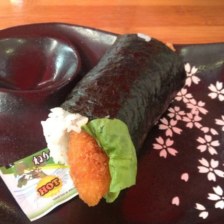

In [20]:
# This is the fist image 
trans.show()

### Another way to visualize samples from dataloaders

In [21]:
images_batch,labels_batch=next(iter(train_dataloader))

In [22]:
# First batch of 32 elements
labels_batch

tensor([2, 0, 2, 2, 1, 0, 1, 0, 0, 2, 2, 0, 1, 2, 2, 1, 1, 0, 2, 1, 1, 0, 2, 1,
        1, 1, 2, 0, 1, 0, 1, 0])

In [23]:
# First batch of 32 images
images_batch.shape

torch.Size([32, 3, 224, 224])

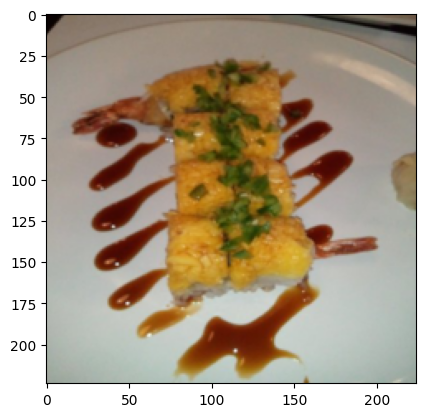

In [24]:
### Using matplotlib's imshow. We will have to permute the shape from channels, height, width to height,width, channels to use with imshow

plt.imshow(torch.permute(images_batch[0],(1,2,0)))

In [25]:
class_names[labels_batch[0]]

'sushi'

***

### We will be coding up these equations and will be referencing the architecture also

\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\mathrm{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

### Creating patches from images- Sorting out the shapes first

In [26]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2)
print(f"No of patches is {number_of_patches}")

image_input_shape=(height,width,color_channels)
image_to_patches_shape=(number_of_patches,(patch_size**2)*color_channels)

print(f'the shape of input image is {image_input_shape}')
print(f'the shape of input image after patching is {image_to_patches_shape}')

No of patches is 196
the shape of input image is (224, 224, 3)
the shape of input image after patching is (196, 768)


#### For processing inside our model, we will have to convert patches which are still of shape 16X16 into embeddings. The embedding length for each patch will be 16X16X3 which is 768. So each patch will be embedded in a tensor of length 768.

#### (196,768) tells us that each image should be converted into 196 patches where each patch is represented by a tensor of shape [768]

#### Visualising a rectangular patch

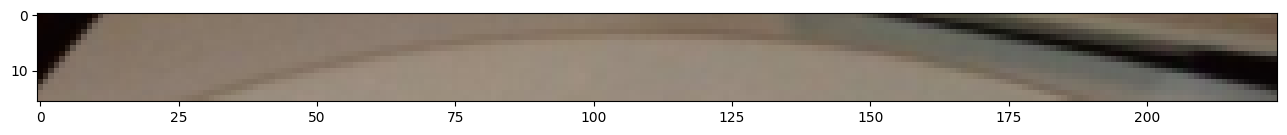

In [27]:
image_permuted = images_batch[0].permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:]);

#### Breaking down the above into smaller patches

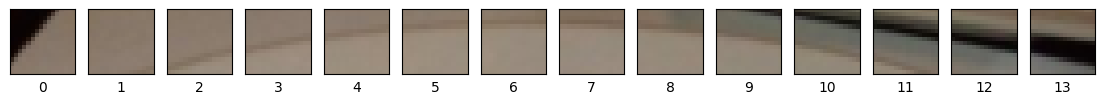

In [28]:
image_size=224
patch_size=16
num_patches=image_size/patch_size

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=image_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)


for i, patch in enumerate(range(0, 224, patch_size)):
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(f'{i}')
  axs[i].set_xticks([])
  axs[i].set_yticks([])

#### Each row of the image gives us 14 patches

#### Now we have patches of shape 16X16.

#### Like this, the whole image needs to be converted into patches- this is the process of patchification.

****

### In the next step, we need to change these patches into embeddings

The operation which we just performed is similar to the process of applying convolution operation on the image.

In [29]:
conv=nn.Conv2d(in_channels=3,out_channels=768,padding=0,kernel_size=patch_size,stride=patch_size)

## Note: I have understood why the out_channels is equal to 768

In [30]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv(images_batch[0].unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [37]:
# In turn, taking the number of feature maps equal to 768 in above equation has given us a resultant feature map of 14X14. Each block in this matrix
# is represented by a tensor of shape 768. This is equivalent to the unrolling operation.
image_out_of_conv[0,:,13,13].shape

torch.Size([768])

The height and width of feature maps is 14,14

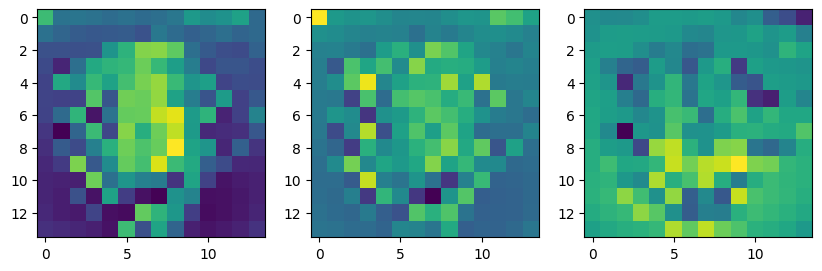

In [31]:
## Lets visualize some feature maps

import random 

random_indices=random.sample(range(0,767),3)

fig,axes=plt.subplots(nrows=1,ncols=3, figsize=(10,10))

for i, idx in enumerate(random_indices):
  feature_map=image_out_of_conv[:,idx,:,:].squeeze().detach().numpy()
  axes[i].imshow(feature_map)



### These feature maps are nothing but learnable embeddings 

## In the above cells, we saw the unrolling operation i.e how to convert patches into embeddings. Now we want to flatten the patches to get the embeddings into correct shape

In [40]:
### Flattening patch embeddings to get shape: (196,768)

# Lets see what we have now:
print(image_out_of_conv.shape)


torch.Size([1, 768, 14, 14])


### The above represents a feature map of dimension 14X14. Each cell of the feature map is represented by a tensor of shape 768. This in turn is telling us that each cell in the feature map is the embedding representing each patch of the image

In [41]:
image_out_of_conv_reshaped=image_out_of_conv.view(1,768,196)

In [42]:
# This tells us that our image has been broken down into 196 patches and each patch is represented by an embedding of size 768
image_out_of_conv_reshaped.shape

torch.Size([1, 768, 196])

In [43]:
# A bit of rearrangement of tensor

image_out_of_conv_rearranged=image_out_of_conv_reshaped.permute(0,2,1)

In [44]:
image_out_of_conv_rearranged.shape

torch.Size([1, 196, 768])

### This looks more like the expected input tensor which needs to be passed inside ViT

*****

## Putting all of the other in one place below: